In [1]:
from pathlib import Path

folder = Path("data/xlsx")

xlsx_files = [
    str(file) for file in
    folder.glob("*.xlsx")
]

print(xlsx_files)


['data\\xlsx\\2024_C6H6_1g.xlsx', 'data\\xlsx\\2024_CO_1g.xlsx', 'data\\xlsx\\2024_NO2_1g.xlsx', 'data\\xlsx\\2024_O3_1g.xlsx', 'data\\xlsx\\2024_PM10_1g.xlsx', 'data\\xlsx\\2024_PM25_1g.xlsx', 'data\\xlsx\\2024_SO2_1g.xlsx']


In [2]:
import pandas as pd

csv_files = []
for file_path in xlsx_files:
    csv_path = file_path.replace("xlsx", "csv")
    csv_files.append(csv_path)

    df = pd.read_excel(file_path)
    df.to_csv(csv_path, index=False)


In [3]:
import pandas as pd

THE_CODE = "WmOlsPuszkin"


def get_column_from_file(csv_path: str) -> pd.DataFrame:
    name = Path(csv_path).stem.split("_")[1]

    df = pd.read_csv(csv_path, low_memory=False)

    columns_to_keep = [df.columns[0]]

    for col in df.columns[1:]:
        if df[col].iloc[0] == THE_CODE:
            columns_to_keep.append(col)
            break

    df = df[columns_to_keep]

    df = df.iloc[5:].reset_index(drop=True)

    df.columns = ["time", name]

    return df, name


dfs = []
names = []
for csv_path in csv_files:
    df, name = get_column_from_file(csv_path)
    names.append(name)
    dfs.append(df)

df = dfs[0]

for the_df in dfs[1:]:
    df = df.merge(the_df, on="time", how="inner")

df["time"] = pd.to_datetime(df["time"], errors="coerce")
for col in names:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df.to_csv("data/combined_data.csv", index=False)
print(df.head())


                 time  C6H6     CO  NO2    O3  PM10  PM25   SO2
0 2024-01-01 01:00:00  0.63  0.342  8.6  42.3  39.2  37.4  11.3
1 2024-01-01 02:00:00  0.52  0.342  5.3  43.8  19.6  18.8   9.5
2 2024-01-01 03:00:00  0.57  0.351  6.3  41.4  19.8  19.0   9.5
3 2024-01-01 04:00:00  0.58  0.352  5.6  40.9  19.4  18.7   9.7
4 2024-01-01 05:00:00  0.61  0.368  5.9  39.7  19.8  19.0  10.1


In [4]:
import numpy as np

df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df['day_of_year'] = df['time'].dt.dayofyear

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)

df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

print(df[['time', 'hour', 'day_of_week', 'day_of_year',
          'hour_sin', 'hour_cos', 
          'day_of_week_sin', 'day_of_week_cos', 
          'day_sin', 'day_cos']].head())


                 time  hour  day_of_week  day_of_year  hour_sin  hour_cos  \
0 2024-01-01 01:00:00     1            0            1  0.258819  0.965926   
1 2024-01-01 02:00:00     2            0            1  0.500000  0.866025   
2 2024-01-01 03:00:00     3            0            1  0.707107  0.707107   
3 2024-01-01 04:00:00     4            0            1  0.866025  0.500000   
4 2024-01-01 05:00:00     5            0            1  0.965926  0.258819   

   day_of_week_sin  day_of_week_cos   day_sin   day_cos  
0              0.0              1.0  0.017213  0.999852  
1              0.0              1.0  0.017213  0.999852  
2              0.0              1.0  0.017213  0.999852  
3              0.0              1.0  0.017213  0.999852  
4              0.0              1.0  0.017213  0.999852  


In [18]:
X = df[names].copy()

print("Macierz cech X:")
print(X.head())
print("\nRozmiar macierzy:", X.shape)


Macierz cech X:
   C6H6     CO  NO2    O3  PM10  PM25   SO2
0  0.63  0.342  8.6  42.3  39.2  37.4  11.3
1  0.52  0.342  5.3  43.8  19.6  18.8   9.5
2  0.57  0.351  6.3  41.4  19.8  19.0   9.5
3  0.58  0.352  5.6  40.9  19.4  18.7   9.7
4  0.61  0.368  5.9  39.7  19.8  19.0  10.1

Rozmiar macierzy: (8784, 7)


In [19]:
null_counts = X.isnull().sum()
null_percent = (X.isnull().mean() * 100).round(2)

print("Null counts per column:")
print(null_counts)
print("\nNull percentage per column (%):")
print(null_percent)

rows_with_nulls = X[X.isnull().any(axis=1)]
print(f"\nRows with any nulls: {len(rows_with_nulls)} (showing first 5 rows)")
print(rows_with_nulls.head())


Null counts per column:
C6H6    454
CO      167
NO2     153
O3      171
PM10    131
PM25    131
SO2     157
dtype: int64

Null percentage per column (%):
C6H6    5.17
CO      1.90
NO2     1.74
O3      1.95
PM10    1.49
PM25    1.49
SO2     1.79
dtype: float64

Rows with any nulls: 537 (showing first 5 rows)
      C6H6     CO   NO2    O3  PM10  PM25  SO2
610    NaN  0.382   7.8  55.8   9.1   8.2  4.8
611    NaN  0.347   5.8  62.3   5.9   4.9  4.8
612    NaN  0.359   7.6  61.0   7.1   6.1  5.0
613    NaN  0.386  13.5  53.1  11.3  10.4  5.4
1248   0.5    NaN   7.1  44.0  22.4  21.2  7.1


In [20]:
X = df[names].copy().dropna()

print("Macierz cech X:")
print(X.head())
print("\nRozmiar macierzy:", X.shape)


Macierz cech X:
   C6H6     CO  NO2    O3  PM10  PM25   SO2
0  0.63  0.342  8.6  42.3  39.2  37.4  11.3
1  0.52  0.342  5.3  43.8  19.6  18.8   9.5
2  0.57  0.351  6.3  41.4  19.8  19.0   9.5
3  0.58  0.352  5.6  40.9  19.4  18.7   9.7
4  0.61  0.368  5.9  39.7  19.8  19.0  10.1

Rozmiar macierzy: (8247, 7)


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled_array = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled_array, columns=names)

print("Standaryzowane dane:")
print(X_scaled.head())
print("\nŚrednia kolumn po standaryzacji:")
print(X_scaled.mean())
print("\nWariancja kolumn po standaryzacji:")
print(X_scaled.var())


Standaryzowane dane:
       C6H6        CO       NO2        O3      PM10      PM25       SO2
0 -0.021748  0.306550 -0.240931 -0.470766  1.650224  2.581364  1.888973
1 -0.203001  0.306550 -0.629540 -0.413299 -0.002099  0.455083  1.156762
2 -0.120613  0.383183 -0.511780 -0.505246  0.014762  0.477946  1.156762
3 -0.104136  0.391698 -0.594212 -0.524402 -0.018959  0.443651  1.238119
4 -0.054703  0.527936 -0.558884 -0.570375  0.014762  0.477946  1.400832

Średnia kolumn po standaryzacji:
C6H6   -2.757047e-16
CO      2.757047e-17
NO2    -6.892618e-17
O3      8.271141e-17
PM10   -2.067785e-17
PM25   -1.102819e-16
SO2     1.240671e-16
dtype: float64

Wariancja kolumn po standaryzacji:
C6H6    1.000121
CO      1.000121
NO2     1.000121
O3      1.000121
PM10    1.000121
PM25    1.000121
SO2     1.000121
dtype: float64


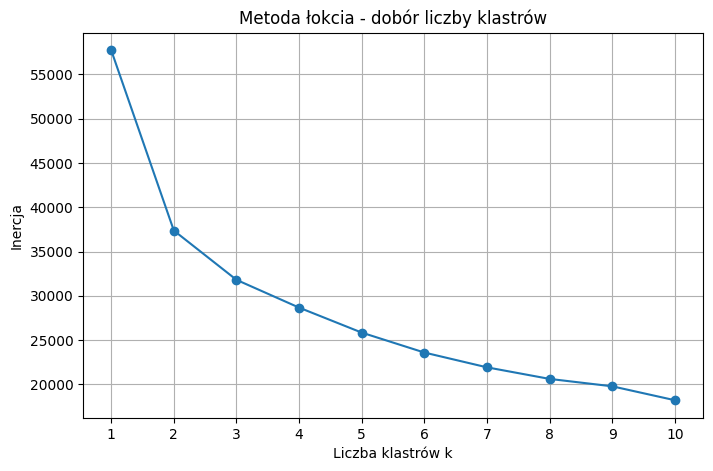

In [22]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia_list = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia_list.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(range(1, 11), inertia_list, marker='o')
plt.title("Metoda łokcia - dobór liczby klastrów")
plt.xlabel("Liczba klastrów k")
plt.ylabel("Inercja")
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()


In [ ]:
from sklearn.cluster import KMeans


def run_kmeans(X_scaled, df_original, n_clusters=3, random_state=42):
    """
    Funkcja wykonuje klasteryzację KMeans i dodaje kolumnę 'Cluster' do oryginalnego DataFrame.
    
    Parametry:
    - X_scaled: DataFrame ze standaryzowanymi cechami
    - df_original: oryginalny DataFrame (nie standaryzowany)
    - n_clusters: liczba klastrów do utworzenia
    - random_state: dla powtarzalności wyników
    
    Zwraca:
    - df z dodaną kolumną 'Cluster'
    - model KMeans
    """
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(X_scaled)
    
    df_result = df_original.copy()
    df_result['Cluster'] = clusters
    
    return df_result, kmeans


df_with_clusters, kmeans_model = run_kmeans(X_scaled, df.dropna(), n_clusters=3)

print(df_with_clusters[['time', 'Cluster'] + names].head())


                 time  Cluster  C6H6     CO  NO2    O3  PM10  PM25   SO2
0 2024-01-01 01:00:00        0  0.63  0.342  8.6  42.3  39.2  37.4  11.3
1 2024-01-01 02:00:00        0  0.52  0.342  5.3  43.8  19.6  18.8   9.5
2 2024-01-01 03:00:00        0  0.57  0.351  6.3  41.4  19.8  19.0   9.5
3 2024-01-01 04:00:00        0  0.58  0.352  5.6  40.9  19.4  18.7   9.7
4 2024-01-01 05:00:00        0  0.61  0.368  5.9  39.7  19.8  19.0  10.1


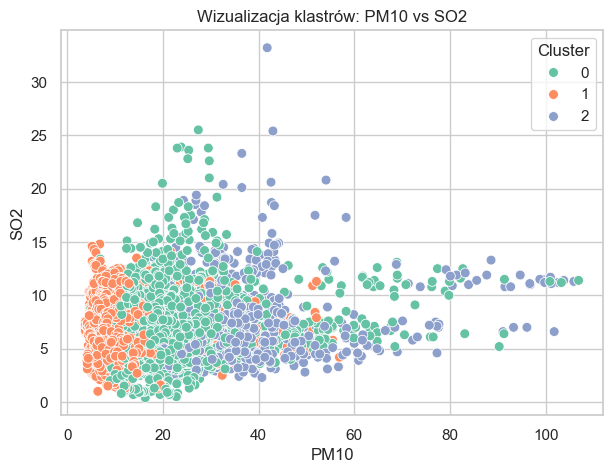

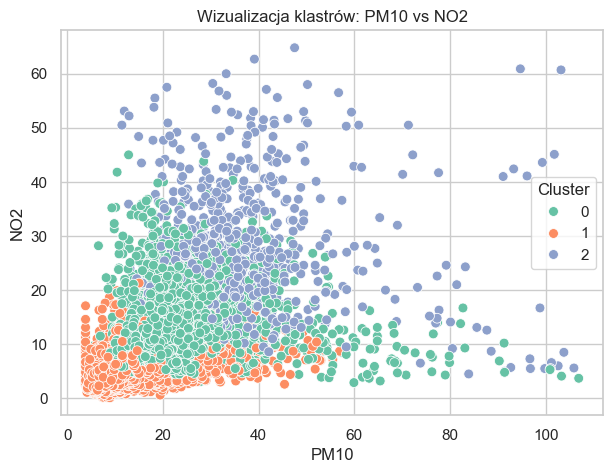

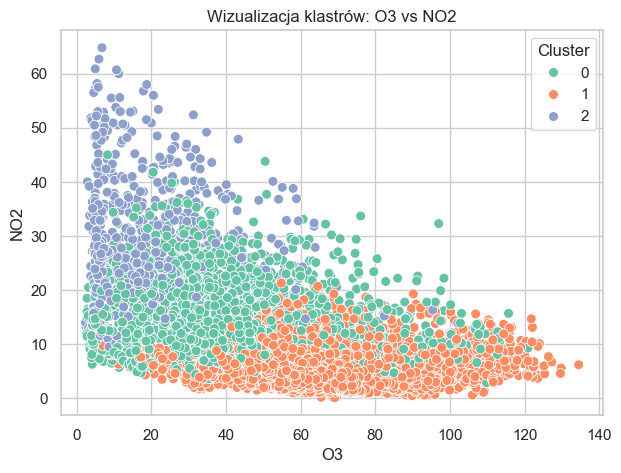

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_clusters_2D(df, pairs):
    """
    Funkcja tworzy wykresy 2D punktów z klastrami.
    
    Parametry:
    - df: DataFrame zawierający kolumnę 'Cluster'
    - pairs: lista krotek (x_var, y_var), np. [("PM10", "SO2"), ("PM10", "NO2")]
    
    Efekt: generuje wykresy 2D dla każdej pary zmiennych
    """
    sns.set(style="whitegrid", palette="muted")
    
    for x_var, y_var in pairs:
        plt.figure(figsize=(7,5))
        sns.scatterplot(
            data=df, 
            x=x_var, y=y_var, 
            hue="Cluster", 
            palette="Set2", 
            s=50
        )
        plt.title(f"Wizualizacja klastrów: {x_var} vs {y_var}")
        plt.xlabel(x_var)
        plt.ylabel(y_var)
        plt.legend(title="Cluster")
        plt.show()


pairs_to_plot = [("PM10", "SO2"), ("PM10", "NO2"), ("O3", "NO2")]
plot_clusters_2D(df_with_clusters, pairs_to_plot)


In [26]:
from sklearn.decomposition import PCA

# Tworzymy PCA na 2 komponenty
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)

# Dodajemy kolumny PCA1 i PCA2 do DataFrame
df_with_clusters['PCA1'] = pca_result[:, 0]
df_with_clusters['PCA2'] = pca_result[:, 1]

# Wyświetlamy wartości własne i procent wariancji wyjaśnionej
explained_variance = pca.explained_variance_ratio_
print("Wartości własne (procent wariancji wyjaśnionej):")
for i, var in enumerate(explained_variance):
    print(f"PCA{i+1}: {var*100:.2f}%")

# Wyświetlamy wektory własne (składniki głównych składowych)
components = pd.DataFrame(pca.components_, columns=names, index=['PCA1', 'PCA2'])
print("\nWektory własne (dominujące zmienne w PCA):")
print(components)


Wartości własne (procent wariancji wyjaśnionej):
PCA1: 55.22%
PCA2: 14.88%

Wektory własne (dominujące zmienne w PCA):
          C6H6        CO       NO2        O3      PM10      PM25       SO2
PCA1  0.457706  0.406119  0.422053 -0.321698  0.357119  0.448023  0.125285
PCA2 -0.164477 -0.063338 -0.135660  0.550518  0.481727  0.192551  0.615081


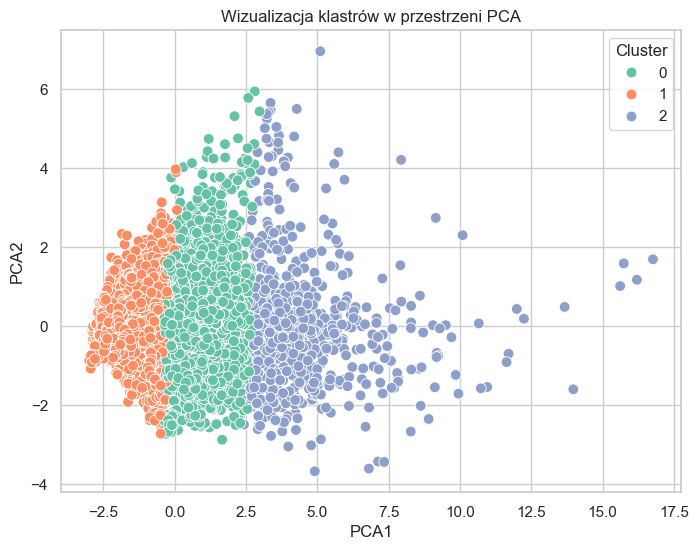

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_pca_clusters(df, pca1='PCA1', pca2='PCA2', cluster_col='Cluster'):
    """
    Funkcja tworzy wykres 2D PCA z kolorowaniem według klastra.
    
    Parametry:
    - df: DataFrame zawierający kolumny PCA1, PCA2 i numer klastra
    - pca1, pca2: nazwy kolumn z PCA
    - cluster_col: nazwa kolumny z numerami klastrów
    """
    sns.set(style="whitegrid", palette="muted")
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=df,
        x=pca1,
        y=pca2,
        hue=cluster_col,
        palette="Set2",
        s=60
    )
    plt.title("Wizualizacja klastrów w przestrzeni PCA")
    plt.xlabel(pca1)
    plt.ylabel(pca2)
    plt.legend(title="Cluster")
    plt.show()


plot_pca_clusters(df_with_clusters)


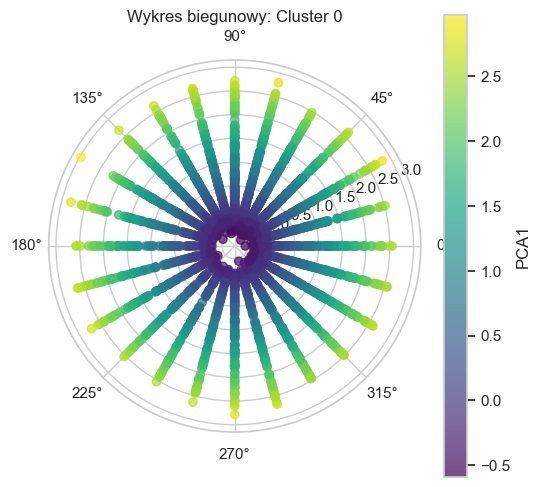

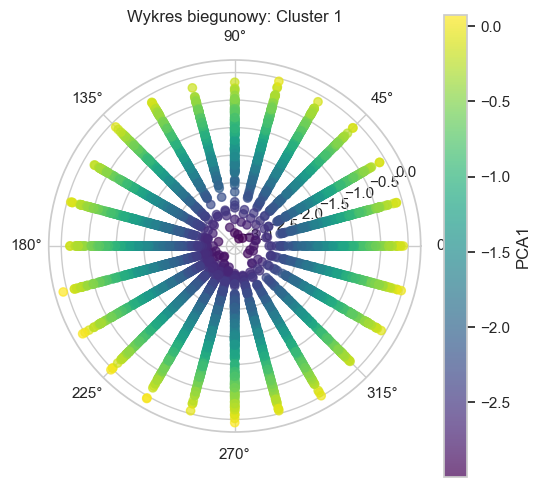

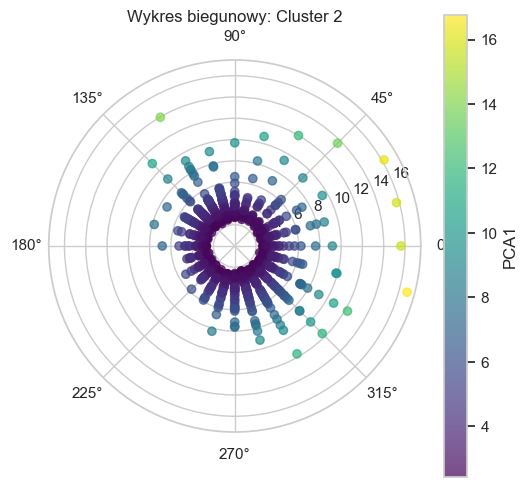

In [28]:
import matplotlib.pyplot as plt
import numpy as np


def polar_plot_by_cluster(df, cluster_col='Cluster', hour_sin_col='hour_sin', hour_cos_col='hour_cos', radius_col='PCA1'):
    """
    Funkcja tworzy wykresy biegunowe PCA1 vs pora dnia dla każdego klastra.
    """
    clusters = df[cluster_col].unique()
    clusters.sort()
    
    for cluster in clusters:
        df_cluster = df[df[cluster_col] == cluster].copy()
        
        # Obliczamy kąt w radianach
        theta = np.arctan2(df_cluster[hour_sin_col], df_cluster[hour_cos_col])
        r = df_cluster[radius_col]
        
        plt.figure(figsize=(6,6))
        ax = plt.subplot(111, polar=True)
        scatter = ax.scatter(theta, r, c=r, cmap='viridis', alpha=0.7)
        plt.title(f"Wykres biegunowy: Cluster {cluster}")
        plt.colorbar(scatter, label=radius_col)
        plt.show()


polar_plot_by_cluster(df_with_clusters)
